In [1]:
import os
import sys
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

%matplotlib inline

import cv2
from sklearn.model_selection import train_test_split

from tqdm import tqdm_notebook #, tnrange
#from itertools import chain
from skimage.io import imread, imshow, imsave #, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model, save_model
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add, SpatialDropout2D, Reshape
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.activations import elu
from keras.layers import LeakyReLU, Dense
from keras.layers import GlobalAveragePooling2D, Multiply, multiply, add

import keras
import tensorflow as tf

from keras.preprocessing.image import array_to_img, img_to_array, load_img#,save_img
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral
from skimage.color import gray2rgb
from skimage.color import rgb2gray

import time
t_start = time.time()


Using TensorFlow backend.


In [2]:
version = 5
basic_name = f'Unet_resnet_v{version}'
save_model_name = basic_name + '.model'
submission_file = basic_name + '.csv'

print(save_model_name)
print(submission_file)

Unet_resnet_v5.model
Unet_resnet_v5.csv


In [3]:
img_size_ori = 101
img_size_target = 101

def upsample(img):# not used
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    
def downsample(img):# not used
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)

In [4]:
# Loading of training/testing ids and depths
train_df = pd.read_csv("train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

len(train_df)

4000

In [5]:
train_df["images"] = [np.array(load_img("train/images/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]

/home/piotr/.local/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [6]:
train_df["masks"] = [np.array(load_img("train/masks/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]

/home/piotr/.local/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [7]:
#### Reference  from Heng's discussion
# https://www.kaggle.com/c/tgs-salt-identification-challenge/discussion/63984#382657
def get_mask_type(mask):
    border = 10
    outer = np.zeros((101-2*border, 101-2*border), np.float32)
    outer = cv2.copyMakeBorder(outer, border, border, border, border, borderType = cv2.BORDER_CONSTANT, value = 1)

    cover = (mask>0.5).sum()
    if cover < 8:
        return 0 # empty
    if cover == ((mask*outer) > 0.5).sum():
        return 1 #border
    if np.all(mask==mask[0]):
        return 2 #vertical

    percentage = cover/(101*101)
    if percentage < 0.15:
        return 3
    elif percentage < 0.25:
        return 4
    elif percentage < 0.50:
        return 5
    elif percentage < 0.75:
        return 6
    else:
        return 7

def histcoverage(coverage):
    histall = np.zeros((1,8))
    for c in coverage:
        histall[0,c] += 1
    return histall

train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_target, 2)

train_df["coverage_class"] = train_df.masks.map(get_mask_type)


/home/piotr/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,0,'Coverage class')

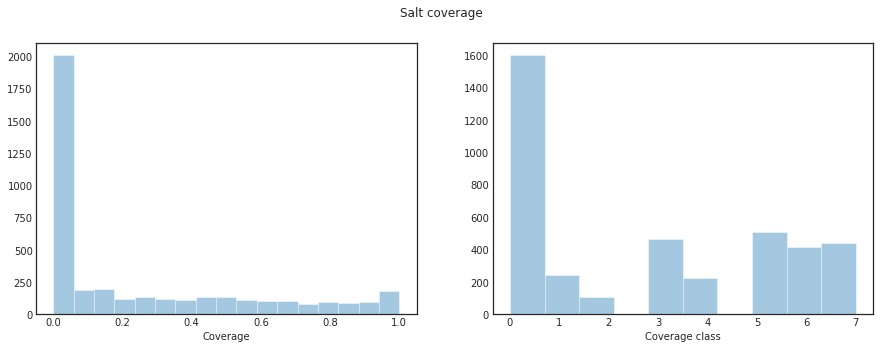

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.distplot(train_df.coverage, kde=False, ax=axs[0])
sns.distplot(train_df.coverage_class, bins=10, kde=False, ax=axs[1])
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")


/home/piotr/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Depth distribution')

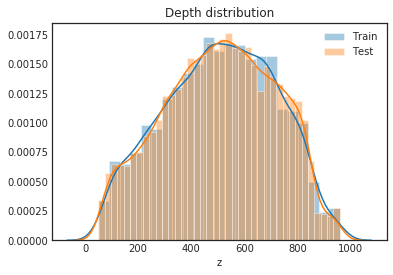

In [9]:
#Plotting the depth distributions¶

sns.distplot(train_df.z, label="Train")
sns.distplot(test_df.z, label="Test")
plt.legend()
plt.title("Depth distribution")

In [10]:
# Create train/validation split stratified by salt coverage

ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
    train_df.index.values,
    np.array(train_df.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    np.array(train_df.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    train_df.coverage.values,
    train_df.z.values,
    test_size=0.2, stratify=train_df.coverage_class, random_state= 13372)


In [11]:
def BatchActivate(x):
    x = BatchNormalization()(x)
    x = Activation("softplus")(x)
    #x = LeakyReLU(alpha=0.3)(x)
    #x = Lambda(lambda x :elu(x) + 1)(x)
    return x

def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    if activation == True:
        x = BatchActivate(x)
    return x

def residual_block(blockInput, num_filters=16, batch_activate = False, squeeze_excite = False):
    x = BatchActivate(blockInput)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    if squeeze_excite:
        x = scSE(x)
    x = Add()([x, blockInput])
    if batch_activate:
        x = BatchActivate(x)
    
    return x

def cse_block(in_block, ch, ratio=16):
    x = GlobalAveragePooling2D()(in_block)
    x = Dense(ch//ratio)(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = Dense(ch, activation='sigmoid')(x)
    return Multiply()([in_block, x])

#channel squeeze, spatial excitation
def sSE(input_features):
    squeezed = Conv2D(1,kernel_size=(1,1),strides=(1,1),padding='same',activation="sigmoid", use_bias="false")(input_features)
    excited = multiply([squeezed,input_features])
    return excited

#spatial squeeze, channel excitation
def cSE(input_features, ratio = 2):
    
    filters = int(input_features.get_shape()[-1])
    squeezed = GlobalAveragePooling2D()(input_features)
    squeezed = Reshape((1,1,-1))(squeezed)
    squeezed = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(squeezed)
    squeezed = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(squeezed)
    
    excited = multiply([squeezed,input_features])
    return excited

#both 
def scSE(input_features, ratio = 2):
    _cse = sSE(input_features)
    _sse = cSE(input_features,ratio)
    return add([_cse,_sse])

def UpSampling2DBilinear(size):
    return Lambda(lambda x: tf.image.resize_bilinear(x, size, align_corners=True))

In [38]:
# Build model
def build_model(input_layer, start_neurons, DropoutRatio = 0.5):
    # 101 -> 50
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(input_layer)
    conv1 = residual_block(conv1,start_neurons * 1)
    conv1 = residual_block(conv1,start_neurons * 1, True)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(DropoutRatio/2)(pool1)

    # 50 -> 25
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(pool1)
    conv2 = residual_block(conv2,start_neurons * 2)
    conv2 = residual_block(conv2,start_neurons * 2, True)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(DropoutRatio)(pool2)

    # 25 -> 12
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(pool2)
    conv3 = residual_block(conv3,start_neurons * 4)
    conv3 = residual_block(conv3,start_neurons * 4, True)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(DropoutRatio)(pool3)

    # 12 -> 6
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(pool3)
    conv4 = residual_block(conv4,start_neurons * 8)
    conv4 = residual_block(conv4,start_neurons * 8, True)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(DropoutRatio)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block(convm,start_neurons * 16)
    convm = residual_block(convm,start_neurons * 16, True)
    
    # 6 -> 12
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(DropoutRatio)(uconv4)
    
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 8)
    uconv4 = residual_block(uconv4,start_neurons * 8, True, False)
    
    # 12 -> 25
    #deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="valid")(uconv4)
    uconv3 = concatenate([deconv3, conv3])    
    uconv3 = Dropout(DropoutRatio)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 4)
    uconv3 = residual_block(uconv3,start_neurons * 4, True,False)

    # 25 -> 50
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
        
    uconv2 = Dropout(DropoutRatio)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 2)
    uconv2 = residual_block(uconv2,start_neurons * 2, True,False)
    
    # 50 -> 101
    #deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="valid")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    
    uconv1 = Dropout(DropoutRatio)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 1)
    uconv1 = residual_block(uconv1,start_neurons * 1, True,False)
    
    #uconv1 = Dropout(DropoutRatio/2)(uconv1)
    #output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    output_layer_noActi = Conv2D(1, (1,1), padding="same", activation=None)(uconv1)
    output_layer =  Activation('sigmoid')(output_layer_noActi)
    
    return output_layer

In [13]:
def get_iou_vector(A, B):
    batch_size = A.shape[0]
    metric = []
    for batch in range(batch_size):
        t, p = A[batch]>0, B[batch]>0
#         if np.count_nonzero(t) == 0 and np.count_nonzero(p) > 0:
#             metric.append(0)
#             continue
#         if np.count_nonzero(t) >= 1 and np.count_nonzero(p) == 0:
#             metric.append(0)
#             continue
#         if np.count_nonzero(t) == 0 and np.count_nonzero(p) == 0:
#             metric.append(1)
#             continue
        
        intersection = np.logical_and(t, p)
        union = np.logical_or(t, p)
        iou = (np.sum(intersection > 0) + 1e-10 )/ (np.sum(union > 0) + 1e-10)
        thresholds = np.arange(0.5, 1, 0.05)
        s = []
        for thresh in thresholds:
            s.append(iou > thresh)
        metric.append(np.mean(s))

    return np.mean(metric)

def my_iou_metric(label, pred):
    return tf.py_func(get_iou_vector, [label, pred>0.5], tf.float64)

def my_iou_metric_2(label, pred):
    return tf.py_func(get_iou_vector, [label, pred >0], tf.float64)

In [14]:
# code download from: https://github.com/bermanmaxim/LovaszSoftmax
def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    gts = tf.reduce_sum(gt_sorted)
    intersection = gts - tf.cumsum(gt_sorted)
    union = gts + tf.cumsum(1. - gt_sorted)
    jaccard = 1. - intersection / union
    jaccard = tf.concat((jaccard[0:1], jaccard[1:] - jaccard[:-1]), 0)
    return jaccard


# --------------------------- BINARY LOSSES ---------------------------

def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        def treat_image(log_lab):
            log, lab = log_lab
            log, lab = tf.expand_dims(log, 0), tf.expand_dims(lab, 0)
            log, lab = flatten_binary_scores(log, lab, ignore)
            return lovasz_hinge_flat(log, lab)
        losses = tf.map_fn(treat_image, (logits, labels), dtype=tf.float32)
        loss = tf.reduce_mean(losses)
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss


def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """

    def compute_loss():
        labelsf = tf.cast(labels, logits.dtype)
        signs = 2. * labelsf - 1.
        errors = 1. - logits * tf.stop_gradient(signs)
        errors_sorted, perm = tf.nn.top_k(errors, k=tf.shape(errors)[0], name="descending_sort")
        gt_sorted = tf.gather(labelsf, perm)
        grad = lovasz_grad(gt_sorted)
        loss = tf.tensordot(tf.nn.relu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_void")
        return loss

    # deal with the void prediction case (only void pixels)
    loss = tf.cond(tf.equal(tf.shape(logits)[0], 0),
                   lambda: tf.reduce_sum(logits) * 0.,
                   compute_loss,
                   strict=True,
                   name="loss"
                   )
    return loss


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = tf.reshape(scores, (-1,))
    labels = tf.reshape(labels, (-1,))
    if ignore is None:
        return scores, labels
    valid = tf.not_equal(labels, ignore)
    vscores = tf.boolean_mask(scores, valid, name='valid_scores')
    vlabels = tf.boolean_mask(labels, valid, name='valid_labels')
    return vscores, vlabels

def lovasz_loss(y_true, y_pred):
    y_true, y_pred = K.cast(K.squeeze(y_true, -1), 'int32'), K.cast(K.squeeze(y_pred, -1), 'float32')
    #logits = K.log(y_pred / (1. - y_pred))
    logits = y_pred #Jiaxin
    loss = lovasz_hinge(logits, y_true, per_image = True, ignore = None)
    return loss

In [15]:
#Data augmentation
x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)
print(x_train.shape)
print(y_valid.shape)

(6400, 101, 101, 1)
(800, 101, 101, 1)


In [16]:
# #append validation data
# x_train = np.append(x_train, [np.fliplr(x) for x in x_valid], axis=0)
# y_train = np.append(y_train, [np.fliplr(x) for x in y_valid], axis=0)

# x_train = np.append(x_train,x_valid, axis=0)
# y_train = np.append(y_train,y_valid, axis=0)
# print(x_train.shape)
# print(y_valid.shape)

In [17]:
# model
input_layer = Input((img_size_target, img_size_target, 1))
output_layer = build_model(input_layer, 16,0.25)

model1 = Model(input_layer, output_layer)

c = optimizers.adam(lr = 0.01)
model1.compile(loss="binary_crossentropy", optimizer=c, metrics=[my_iou_metric])

model1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 101, 101, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 101, 101, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 101, 101, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 101, 101, 16) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [18]:
# we create two instances with the same arguments
data_gen_args = dict(#featurewise_center=True,
                     #featurewise_std_normalization=True,
                     #rotation_range=18,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.1,
                     fill_mode='reflect',
                     #shear_range = 12,
                     
                     )
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)
# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1
image_datagen.fit(x_train, augment=True, seed=seed)
mask_datagen.fit(y_train, augment=True, seed=seed)

image_generator = image_datagen.flow(x_train,batch_size = 16,seed=seed)
mask_generator = mask_datagen.flow(y_train,batch_size = 16,seed=seed)

train_generator = zip(image_generator,mask_generator)

In [19]:
model1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 101, 101, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 101, 101, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 101, 101, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 101, 101, 16) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [20]:
# from segmentation_models import Unet
# c = optimizers.adam(lr = 0.01)
# model1 = Unet(backbone_name='resnet34', encoder_weights='imagenet')

In [21]:
c = optimizers.adam(lr = 0.01)
model1.compile(loss="binary_crossentropy", optimizer=c, metrics=[my_iou_metric])

In [22]:
#early_stopping = EarlyStopping(monitor='my_iou_metric', mode = 'max',patience=10, verbose=1)
model_checkpoint = ModelCheckpoint(save_model_name,monitor='val_my_iou_metric', 
                                   mode = 'max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric', mode = 'max',factor=0.8, patience=6, min_lr=0.001, verbose=1)

epochs = 50
batch_size = 16
history = model1.fit(x_train, y_train,
                     validation_data=[x_valid, y_valid], 
                     epochs=epochs,
                     batch_size=batch_size,
                     callbacks=[ model_checkpoint,reduce_lr], 
                     verbose=1)

# history = model1.fit_generator(train_generator,
#                      validation_data=[x_valid, y_valid], 
#                      epochs=epochs,
#                      steps_per_epoch = 100,
#                      callbacks=[ model_checkpoint,reduce_lr], 
#                      verbose=1)

Train on 6400 samples, validate on 800 samples
Epoch 1/50
6400/6400 [==============================] - 57s 9ms/step - loss: 0.5053 - my_iou_metric: 0.3452 - val_loss: 0.5062 - val_my_iou_metric: 0.3850

Epoch 00001: val_my_iou_metric improved from -inf to 0.38500, saving model to Unet_resnet_v5.model
Epoch 2/50
6400/6400 [==============================] - 43s 7ms/step - loss: 0.3528 - my_iou_metric: 0.5054 - val_loss: 0.4122 - val_my_iou_metric: 0.3516

Epoch 00002: val_my_iou_metric did not improve from 0.38500
Epoch 3/50
6400/6400 [==============================] - 43s 7ms/step - loss: 0.3031 - my_iou_metric: 0.5488 - val_loss: 0.3392 - val_my_iou_metric: 0.4977

Epoch 00003: val_my_iou_metric improved from 0.38500 to 0.49775, saving model to Unet_resnet_v5.model
Epoch 4/50
6400/6400 [==============================] - 43s 7ms/step - loss: 0.2600 - my_iou_metric: 0.5729 - val_loss: 0.2326 - val_my_iou_metric: 0.6006

Epoch 00004: val_my_iou_metric improved from 0.49775 to 0.60062, sav

In [24]:
model1 = load_model(save_model_name,custom_objects={'my_iou_metric': my_iou_metric,'elu':elu,'tf':tf})
# remove layter activation layer and use losvasz loss
input_x = model1.layers[0].input

output_layer = model1.layers[-1].input
model = Model(input_x, output_layer)
c = optimizers.adam(lr = 0.01)

# lovasz_loss need input range (-∞，+∞), so cancel the last "sigmoid" activation  
# Then the default threshod for pixel prediction is 0 instead of 0.5, as in my_iou_metric_2.
model.compile(loss=lovasz_loss, optimizer=c, metrics=[my_iou_metric_2])

#model.summary()


In [35]:
c = optimizers.adam(lr = 0.05)

# lovasz_loss need input range (-∞，+∞), so cancel the last "sigmoid" activation  
# Then the default threshod for pixel prediction is 0 instead of 0.5, as in my_iou_metric_2.
model.compile(loss=lovasz_loss, optimizer=c, metrics=[my_iou_metric_2])

In [36]:
# lovasz_loss need input range (-∞，+∞), so cancel the last "sigmoid" activation  
# Then the default threshod for pixel prediction is 0 instead of 0.5, as in my_iou_metric_2.
#c = optimizers.adam(lr = 0.005)
#model.compile(loss=lovasz_loss, optimizer=c, metrics=[my_iou_metric_2])

In [37]:
early_stopping = EarlyStopping(monitor='val_my_iou_metric_2', mode = 'max',patience=40, verbose=1)
model_checkpoint = ModelCheckpoint(save_model_name,monitor='val_my_iou_metric_2', 
                                   mode = 'max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric_2', mode = 'max',factor=0.85, patience=7, min_lr=0.0005, verbose=1)
epochs = 400
batch_size = 16

# history = model.fit_generator(train_generator,
#                      validation_data=[x_valid, y_valid], 
#                      epochs=epochs,
#                      steps_per_epoch = 600,
#                      callbacks=[ model_checkpoint,reduce_lr], 
#                      verbose=1)

history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[ model_checkpoint,reduce_lr,early_stopping], 
                    verbose=1)




Train on 6400 samples, validate on 800 samples
Epoch 1/400
6400/6400 [==============================] - 108s 17ms/step - loss: 0.6028 - my_iou_metric_2: 0.6737 - val_loss: 0.5335 - val_my_iou_metric_2: 0.7071

Epoch 00001: val_my_iou_metric_2 improved from -inf to 0.70712, saving model to Unet_resnet_v5.model
Epoch 2/400
6400/6400 [==============================] - 95s 15ms/step - loss: 0.7076 - my_iou_metric_2: 0.6192 - val_loss: 0.9661 - val_my_iou_metric_2: 0.4963

Epoch 00002: val_my_iou_metric_2 did not improve from 0.70712
Epoch 3/400
6400/6400 [==============================] - 95s 15ms/step - loss: 0.6051 - my_iou_metric_2: 0.6688 - val_loss: 0.5055 - val_my_iou_metric_2: 0.7135

Epoch 00003: val_my_iou_metric_2 improved from 0.70712 to 0.71350, saving model to Unet_resnet_v5.model
Epoch 4/400
6400/6400 [==============================] - 94s 15ms/step - loss: 0.6207 - my_iou_metric_2: 0.6630 - val_loss: 0.5963 - val_my_iou_metric_2: 0.6759

Epoch 00004: val_my_iou_metric_2 did 

KeyboardInterrupt: 

In [ ]:
fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_score.plot(history.epoch, history.history["my_iou_metric_2"], label="Train score")
ax_score.plot(history.epoch, history.history["val_my_iou_metric_2"], label="Validation score")
ax_score.legend()

In [53]:
model = load_model(save_model_name,custom_objects={'my_iou_metric_2': my_iou_metric_2,
                                                   'lovasz_loss': lovasz_loss,'tf':tf})


In [54]:
# #freeze BN #compile after
# for layer in model.layers:
#     if type(layer) is BatchNormalization:
#         layer.trainable = False

In [55]:
def predict_result(model,x_test,img_size_target): # predict both orginal and reflect x
    x_test_reflect =  np.array([np.fliplr(x) for x in x_test])
    preds_test = model.predict(x_test).reshape(-1, img_size_target, img_size_target)
    preds_test2_refect = model.predict(x_test_reflect).reshape(-1, img_size_target, img_size_target)
    preds_test += np.array([ np.fliplr(x) for x in preds_test2_refect] )
    return preds_test/2


In [56]:
preds_valid = predict_result(model,x_valid,img_size_target)


In [57]:
#Score the model and do a threshold optimization by the best IoU.

# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in


    true_objects = 2
    pred_objects = 2

    #  if all zeros, original code  generate wrong  bins [-0.5 0 0.5],
    temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=([0,0.5,1], [0,0.5, 1]))
#     temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))
    #print(temp1)
    intersection = temp1[0]
    #print("temp2 = ",temp1[1])
    #print(intersection.shape)
   # print(intersection)
    # Compute areas (needed for finding the union between all objects)
    #print(np.histogram(labels, bins = true_objects))
    area_true = np.histogram(labels,bins=[0,0.5,1])[0]
    #print("area_true = ",area_true)
    area_pred = np.histogram(y_pred, bins=[0,0.5,1])[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection
  
    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    intersection[intersection == 0] = 1e-9
    
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)


In [58]:


## Scoring for last model, choose threshold by validation data 
thresholds_ori = np.linspace(0.3, 0.7, 31)
# Reverse sigmoid function: Use code below because the  sigmoid activation was removed
thresholds = np.log(thresholds_ori/(1-thresholds_ori)) 

# ious = np.array([get_iou_vector(y_valid, preds_valid > threshold) for threshold in tqdm_notebook(thresholds)])
# print(ious)
ious = np.array([iou_metric_batch(y_valid, preds_valid > threshold) for threshold in tqdm_notebook(thresholds)])
print(ious)




[0.824125 0.82575  0.829    0.8295   0.83     0.83075  0.8305   0.830875
 0.831    0.831875 0.832    0.83225  0.83225  0.834125 0.83375  0.83575
 0.837875 0.83775  0.838    0.83775  0.837875 0.8375   0.83725  0.836875
 0.837    0.83675  0.8365   0.836375 0.837375 0.838125 0.83825 ]


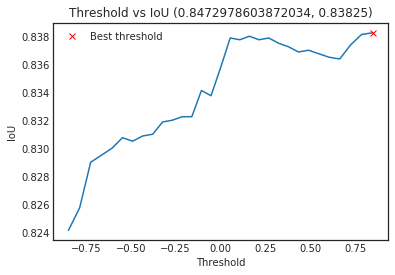

In [59]:
# instead of using default 0 as threshold, use validation data to find the best threshold.
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

In [60]:
#Original_image = Image which has to labelled
#Mask image = Which has been labelled by some technique..
def crf(original_image, mask_img):
    
    # Converting annotated image to RGB if it is Gray scale
    if(len(mask_img.shape)<3):
        mask_img = gray2rgb(mask_img)

#     #Converting the annotations RGB color to single 32 bit integer
    annotated_label = mask_img[:,:,0] + (mask_img[:,:,1]<<8) + (mask_img[:,:,2]<<16)
    
#     # Convert the 32bit integer color to 0,1, 2, ... labels.
    colors, labels = np.unique(annotated_label, return_inverse=True)

    n_labels = 2
    
    #Setting up the CRF model
    d = dcrf.DenseCRF2D(original_image.shape[1], original_image.shape[0], n_labels)

    # get unary potentials (neg log probability)
    U = unary_from_labels(labels, n_labels, gt_prob=0.7, zero_unsure=False)
    d.setUnaryEnergy(U)

    # This adds the color-independent term, features are the locations only.
    d.addPairwiseGaussian(sxy=(3, 3), compat=3, kernel=dcrf.DIAG_KERNEL,
                      normalization=dcrf.NORMALIZE_SYMMETRIC)
        
    #Run Inference for 10 steps 
    Q = d.inference(10)

    # Find out the most probable class for each pixel.
    MAP = np.argmax(Q, axis=0)

    return MAP.reshape((original_image.shape[0],original_image.shape[1]))

In [61]:
"""
used for converting the decoded image to rle mask
Fast compared to previous one
"""
def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


In [62]:
x_test = np.array([upsample(np.array(load_img("test/images/{}.png".format(idx), grayscale=True))) / 255 for idx in tqdm_notebook(test_df.index)]).reshape(-1, img_size_target, img_size_target, 1)



/home/piotr/.local/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [63]:


preds_test = predict_result(model,x_test,img_size_target)



In [64]:
#crf_masks_test = [crf(x_test[i],preds_test[i] > threshold_best) for i in tqdm_notebook(range(x_test.shape[0]))]

In [83]:


t1 = time.time()
pred_dict = {idx: rle_encode(np.round(downsample(preds_test[i]) > 0.3)) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}
t2 = time.time()

print(f"Usedtime = {t2-t1} s")




Usedtime = 5.5192975997924805 s


In [84]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv(submission_file)

In [85]:
t_finish = time.time()
print(f"Kernel run time = {(t_finish-t_start)/3600} hours")


Kernel run time = 12.586112659176191 hours


In [82]:
threshold_best


#with dropout 0.5 batchsize32 LB 0.810

#changed model dropout to 0.25
#changed batch size of seocnd training  to 16

#threshold best -0.106
#achieved LB 0.816
#threshold -0.15 LB 0.816
#threshold -0.3 LB 0.816
#threshold -0.5 LB 0.814

#removed dropout
#finetuning last model with reflective padding data agumentation. <- good for overfitting
#increase model size 4 times by increasing filters 2 time
#increase batchszie to 40 (barchnorm?)
#decrease to 16
#add LeakyRelu

#go back to 0.816 model but with leaky relu

#
#LR 9.000000427477062e-05
#loss: 0.1735 - my_iou_metric_2: 0.8880 - val_loss: 0.3950 - val_my_iou_metric_2: 0.8235
#sSE + hypercolumn
#no agumentation
#dropout 0, size 20
#best lr 0.0003000000142492354.


0.8472978603872034

In [78]:
#remove dropout
#data agumentation? reflective padding?

In [49]:
sub.head

<bound method NDFrame.head of                                                      rle_mask
id                                                           
353e010b7b                                                   
5439dbbddf                                                   
71bab9f311                                                   
52551f7a80                                                   
512d8d9997  1620 1 1719 7 1819 9 1920 10 2021 11 2122 12 2...
64dba827d6                                                   
0a3a8a5f37                                                   
329563756f  1 4039 4041 99 4142 99 4243 98 4344 98 4445 98...
f6cba2e890  4132 6 4142 2 4229 12 4243 3 4325 18 4344 4 44...
989c646373                                                   
8ba0248e74                                                   
d29d1424ce                                                   
9834bd4034                                                   
aa5f085ae7  96 6 197 6 298 6 400 5 502 4

In [ ]:
#TODO maybe excitation, maybe spatial dropout